# 1. Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier

# Modelling Helpers
from sklearn.preprocessing import Normalizer , scale
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, confusion_matrix

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

# 2. Setup Helper Functions

In [2]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

# 3. Load Data

In [3]:
train = pd.read_csv('./data/Titanic/train.csv')
test = pd.read_csv('./data/Titanic/test.csv')

data = train.append(test, ignore_index = True)

titanic = data[:891]
titanic['Survived'] = titanic['Survived'].astype(int)

del train , test

print ('Datasets:' , 'data:' , data.shape , 'titanic:' , titanic.shape)

Datasets: data: (1309, 12) titanic: (891, 12)


In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 3.1. Statistical Summaries and Visualization

In [5]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int32  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int32(1), int64(4), object(5)
memory usage: 80.2+ KB


 ### A heat map of correlation may give us a understanding of which variables are important

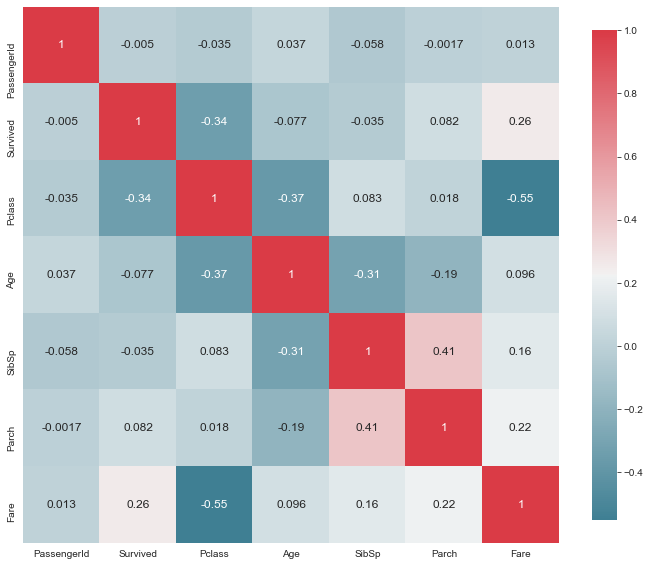

In [8]:
plot_correlation_map(titanic)

###  Let's further explore the relationship between the features and survival of passengers




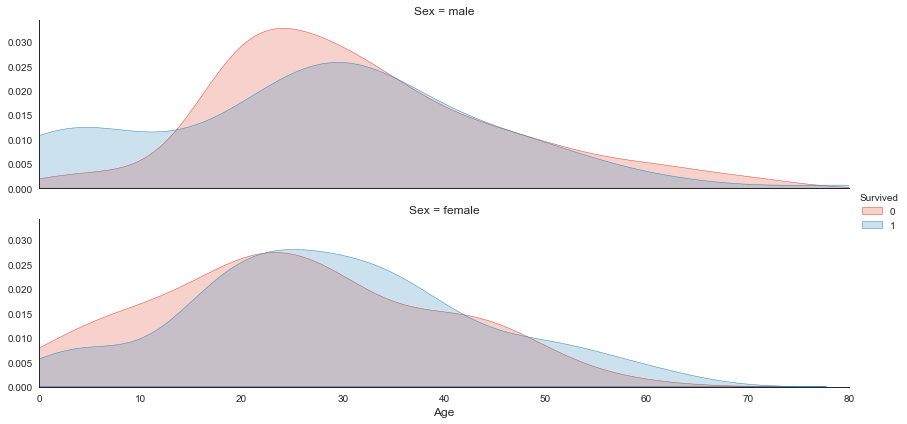

In [9]:
# Plot distributions of Age of passangers who survived or did not survive
plot_distribution(titanic, var = 'Age', target = 'Survived', row = 'Sex')

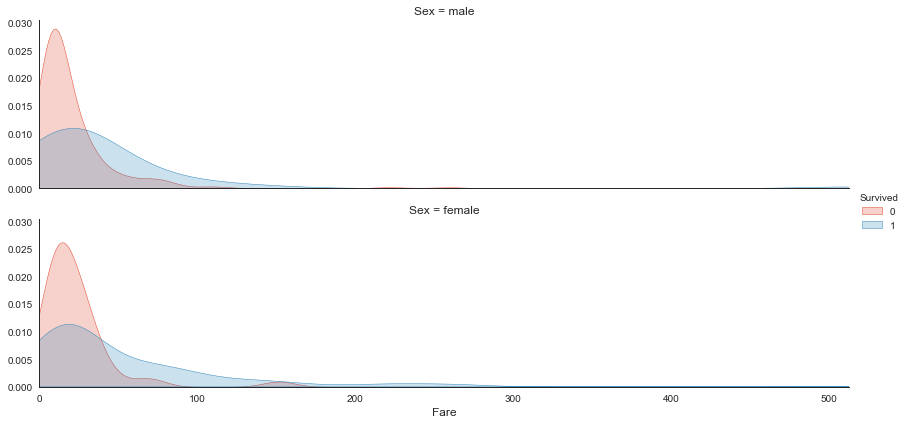

In [10]:
# Plot distributions of Fare of passangers who survived or did not survive
plot_distribution(titanic, var = 'Fare', target = 'Survived', row = 'Sex')

### Embarked
We can also look at categorical variables like Embarked and their relationship with survival.

C = Cherbourg
Q = Queenstown
S = Southampton

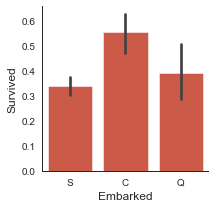

In [11]:
# Plot survival rate by Embarked
plot_categories( titanic , cat = 'Embarked' , target = 'Survived' )

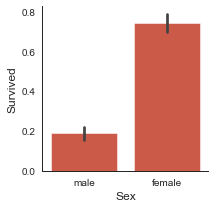

In [12]:
# Plot survival rate by Sex
plot_categories( titanic , cat = 'Sex' , target = 'Survived' )

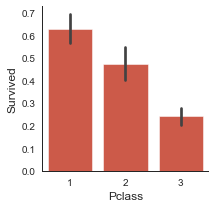

In [13]:
# Plot survival rate by Pclass
plot_categories( titanic , cat = 'Pclass' , target = 'Survived' )

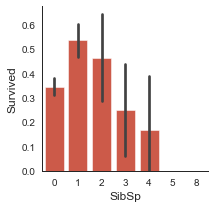

In [14]:
# Plot survival rate by SibSp
plot_categories( titanic , cat = 'SibSp' , target = 'Survived' )

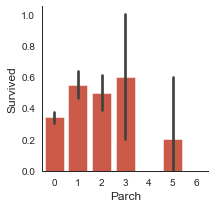

In [15]:
# Plot survival rate by Parch
plot_categories( titanic , cat = 'Parch' , target = 'Survived' )

# 4. Data Preparation

## 4.1. Transform Categorical values into Numerical

In [16]:
# Transform Sex into binary values 0 and 1
sex = pd.Series(np.where(data.Sex == 'male' , 1 , 0 ), name = 'Sex')
sex.head()

0    1
1    0
2    0
3    0
4    1
Name: Sex, dtype: int32

In [17]:
# Create a new variable for every unique value of Embarked
embarked = pd.get_dummies(data.Embarked , prefix='Embarked')
embarked.head()

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [18]:
# Create a new variable for every unique value of Pclass
pclass = pd.get_dummies(data.Pclass , prefix='Pclass')
pclass.head()

,Pclass_1,Pclass_2,Pclass_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


## 4.2. Fill missing values in variables

In [19]:
# Create dataset
imputed = pd.DataFrame()

# Fill missing values of Age with the average of Age (mean)
imputed['Age'] = data.Age.fillna(data.Age.mean())

# Fill missing values of Fare with the average of Fare (mean)
imputed['Fare'] = data.Fare.fillna(data.Fare.mean())

imputed.head()

,Age,Fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500


# 5. Feature Engineering - Create new variables

## 5.1. Extract titles from passenger names

In [20]:
title = pd.DataFrame()
# we extract the title from each name
title['Title'] = data['Name'].map(lambda name: name.split(',')[1].split('.')[0].strip())

# a map of more aggregated titles
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"

                    }

# we map each title
title['Title'] = title.Title.map(Title_Dictionary)
title = pd.get_dummies(title.Title)
#title = pd.concat( [ title , titles_dummies ] , axis = 1 )

title.head()

,Master,Miss,Mr,Mrs,Officer,Royalty
0,0,0,1,0,0,0
1,0,0,0,1,0,0
2,0,1,0,0,0,0
3,0,0,0,1,0,0
4,0,0,1,0,0,0


## 5.2. Extract Cabin category from Cabin number

In [21]:
cabin = pd.DataFrame()

# replacing missing cabins with U (for Uknown)
cabin[ 'Cabin' ] = data.Cabin.fillna( 'U' )

# mapping each Cabin value with the cabin letter
cabin[ 'Cabin' ] = cabin[ 'Cabin' ].map( lambda c : c[0] )

# dummy encoding ...
cabin = pd.get_dummies( cabin['Cabin'] , prefix = 'Cabin' )

cabin.head()

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1


## 5.3. Extract ticket class from ticket number

In [22]:
# a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
def cleanTicket( ticket ):
    ticket = ticket.replace( '.' , '' )
    ticket = ticket.replace( '/' , '' )
    ticket = ticket.split()
    ticket = map( lambda t : t.strip() , ticket )
    ticket = list(filter( lambda t : not t.isdigit() , ticket ))
    if len( ticket ) > 0:
        return ticket[0]
    else: 
        return 'XXX'

ticket = pd.DataFrame()

# Extracting dummy variables from tickets:
ticket[ 'Ticket' ] = data[ 'Ticket' ].map( cleanTicket )
ticket = pd.get_dummies( ticket[ 'Ticket' ] , prefix = 'Ticket' )

ticket.shape
ticket.head()

,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,...,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## 5.4. Create family size and category for family size

In [23]:
family = pd.DataFrame()

# introducing a new feature : the size of families (including the passenger)
family[ 'FamilySize' ] = data[ 'Parch' ] + data[ 'SibSp' ] + 1

# introducing other features based on the family size
family[ 'Family_Single' ] = family[ 'FamilySize' ].map( lambda s : 1 if s == 1 else 0 )
family[ 'Family_Small' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 2 <= s <= 4 else 0 )
family[ 'Family_Large' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 5 <= s else 0 )

family.head()

,FamilySize,Family_Single,Family_Small,Family_Large
0,2,0,1,0
1,2,0,1,0
2,1,1,0,0
3,2,0,1,0
4,1,1,0,0


## 5.5. Assemble final datasets for modelling

In [24]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 5.6. Feature Engineering

In [25]:
# Select which features/variables to include in the dataset from the list below:
# imputed , embarked , pclass , sex , family , cabin , ticket, title

X_data = pd.concat([pclass, title, sex, imputed, cabin, embarked, family], axis=1)
X_data.head()

,Pclass_1,Pclass_2,Pclass_3,Master,Miss,Mr,Mrs,Officer,Royalty,Sex,...,Cabin_G,Cabin_T,Cabin_U,Embarked_C,Embarked_Q,Embarked_S,FamilySize,Family_Single,Family_Small,Family_Large
0,0,0,1,0,0,1,0,0,0,1,...,0,0,1,0,0,1,2,0,1,0
1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,2,0,1,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,1,1,1,0,0
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,2,0,1,0
4,0,0,1,0,0,1,0,0,0,1,...,0,0,1,0,0,1,1,1,0,0


## 5.7. Create Dataset

In [26]:
# Create all datasets that are necessary to train, validate and test models
X = X_data[0:891]
y = titanic.Survived
X_test_data = X_data[891:]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .7)

pd.DataFrame({
    'Data': ['X_data', 'X', 'y', 'X_train', 'y_train', 'X_test', 'y_test', 'test_data'],
    'Shape': [X_data.shape, X.shape, y.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_test_data.shape]
})

,Data,Shape
0,X_data,"(1309, 28)"
1,X,"(891, 28)"
2,y,"(891,)"
3,X_train,"(623, 28)"
4,y_train,"(623,)"
5,X_test,"(268, 28)"
6,y_test,"(268,)"
7,test_data,"(418, 28)"


## 5.8. Feature Importance

0.9903691813804173


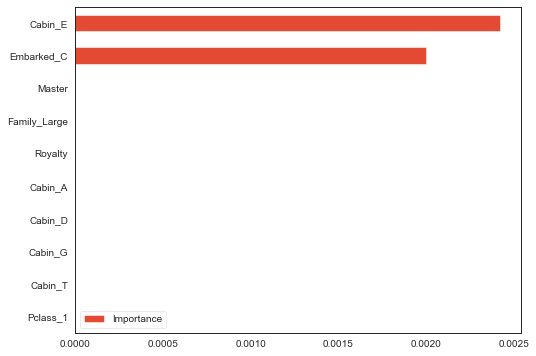

In [27]:
plot_variable_importance(X_train, y_train)

# 6. Modeling

## 6.1. Model Selection

### 6.1.1. Linear Support Vector Machine

In [28]:
linear_svc = SVC(kernel='linear',C=0.1,gamma=0.1)
linear_svc.fit(X_train, y_train)
y_pred_linear = linear_svc.predict(X_test)

acc_linear_svc = round(accuracy_score(y_pred_linear, y_test)*100, 2)
acc_linear_svc

82.84

### 6.1.2. Radial Support Vector Machine

In [29]:
rbf_svc = SVC(kernel='rbf',C=1,gamma=0.1)
rbf_svc.fit(X_train, y_train)
y_pred_rbf = rbf_svc.predict(X_test)

acc_rbf_svc = round(accuracy_score(y_pred_rbf, y_test)*100, 2)
acc_rbf_svc

72.39

### 6.1.3. K-nearest classifier

In [30]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

acc_knn = round(accuracy_score(y_pred_knn, y_test)*100, 2)
acc_knn

69.4

### 6.1.4. Logistic Regression

In [31]:
lrc = LogisticRegression()
lrc.fit(X_train, y_train)
y_pred_lrc = lrc.predict(X_test)

acc_lrc = round(accuracy_score(y_pred_lrc, y_test)*100, 2)
acc_lrc

81.34

### 6.1.5. Random Forest Model

In [32]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)

acc_rfc = round(accuracy_score(y_pred_rfc, y_test)*100, 2)
acc_rfc

79.1

### 6.1.6. Gaussian Naive Bayes

In [33]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)

acc_gnb = round(accuracy_score(y_pred_gnb, y_test)*100, 2)
acc_gnb

79.1

### 6.1.7. Perceptron 

In [34]:
ptc = Perceptron()
ptc.fit(X_train, y_train)
y_pred_ptc = ptc.predict(X_test)

acc_ptc = round(accuracy_score(y_pred_ptc, y_test)*100, 2)
acc_ptc

74.25

### 6.1.8. Gradient Boosting Classifier

In [35]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)

acc_gbc = round(accuracy_score(y_pred_gbc, y_test)*100, 2)
acc_gbc

80.97

### 6.1.9. Decision Tree Classifier

In [36]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred_dtc = dtc.predict(X_test)

acc_dtc = round(accuracy_score(y_pred_dtc, y_test)*100, 2)
acc_dtc

70.15

# 7. Evaluation

## 7.1. Model Performance

In [37]:
models = pd.DataFrame({
    'Model': ['Linear Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Gradient Boosting', 'Decision Tree', 'Radial SVM'],
    'Score': [acc_linear_svc, acc_knn, acc_lrc, 
                    acc_rfc, acc_gnb, acc_ptc, 
                    acc_gbc, acc_dtc, acc_rbf_svc]})
models.sort_values(by='Score', ascending=False)

,Model,Score
0,Linear Support Vector Machines,82.84
2,Logistic Regression,81.34
6,Gradient Boosting,80.97
3,Random Forest,79.10
4,Naive Bayes,79.10
5,Perceptron,74.25
8,Radial SVM,72.39
7,Decision Tree,70.15
1,KNN,69.40


## 7.2. Confusion Matrix

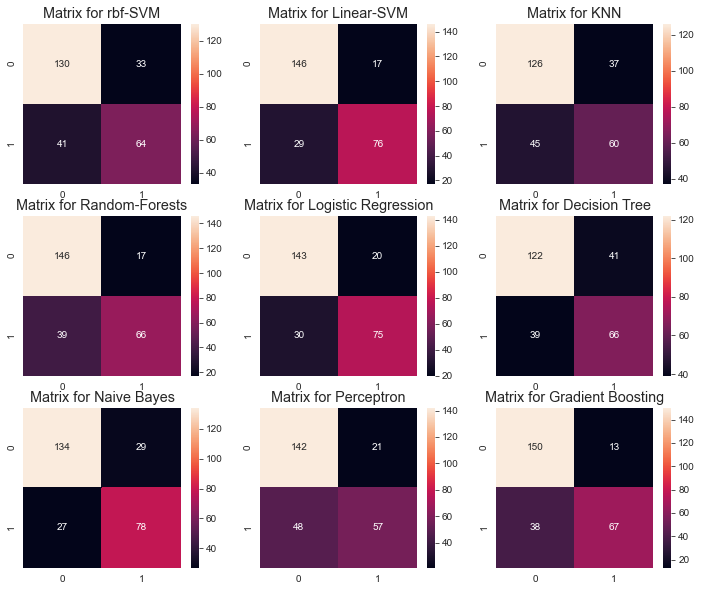

In [38]:
f,ax=plt.subplots(3,3,figsize=(12,10))

sns.heatmap(confusion_matrix(y_test,y_pred_rbf),ax=ax[0,0],annot=True,fmt='2.0f')
ax[0,0].set_title('Matrix for rbf-SVM')

sns.heatmap(confusion_matrix(y_test,y_pred_linear),ax=ax[0,1],annot=True,fmt='2.0f')
ax[0,1].set_title('Matrix for Linear-SVM')

sns.heatmap(confusion_matrix(y_test,y_pred_knn),ax=ax[0,2],annot=True,fmt='2.0f')
ax[0,2].set_title('Matrix for KNN')

sns.heatmap(confusion_matrix(y_test,y_pred_rfc),ax=ax[1,0],annot=True,fmt='2.0f')
ax[1,0].set_title('Matrix for Random-Forests')

sns.heatmap(confusion_matrix(y_test,y_pred_lrc),ax=ax[1,1],annot=True,fmt='2.0f')
ax[1,1].set_title('Matrix for Logistic Regression')

sns.heatmap(confusion_matrix(y_test,y_pred_dtc),ax=ax[1,2],annot=True,fmt='2.0f')
ax[1,2].set_title('Matrix for Decision Tree')

sns.heatmap(confusion_matrix(y_test,y_pred_gnb),ax=ax[2,0],annot=True,fmt='2.0f')
ax[2,0].set_title('Matrix for Naive Bayes')

sns.heatmap(confusion_matrix(y_test,y_pred_ptc),ax=ax[2,1],annot=True,fmt='2.0f')
ax[2,1].set_title('Matrix for Perceptron')

sns.heatmap(confusion_matrix(y_test,y_pred_gbc),ax=ax[2,2],annot=True,fmt='2.0f')
ax[2,2].set_title('Matrix for Gradient Boosting')

plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()

## 7.3. Cross Validation

In [39]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction

kfold = KFold(n_splits=10, random_state=22) # k=10, split the data into 10 equal parts
cv_mean = []
accuracy=[]
std=[]

classifiers=['Linear SVM','Radial SCM','Logistic Regression','KNN','Decision Tree','Naive Bayes','Random Forest', 'Perceptron', 'Gradient Boosting']

models=[SVC(kernel='linear'), SVC(kernel='rbf'), LogisticRegression(), KNeighborsClassifier(n_neighbors=9),DecisionTreeClassifier(),GaussianNB(),RandomForestClassifier(n_estimators=100), Perceptron(), GradientBoostingClassifier()]

for model in models:
    cv_result = cross_val_score(model, X, y, cv = kfold,scoring = "accuracy")
    cv_result = cv_result
    cv_mean.append(round(cv_result.mean()*100, 2))
    std.append(round(cv_result.std()*100, 2))
    accuracy.append(cv_result)
new_models_dataframe2=pd.DataFrame({'CV Mean': cv_mean,'Std': std}, index=classifiers)       
new_models_dataframe2.sort_values(by='CV Mean', ascending=False)

,CV Mean,Std
Gradient Boosting,83.51,3.92
Logistic Regression,83.39,3.50
Linear SVM,82.49,3.59
Random Forest,80.92,3.49
Naive Bayes,78.79,2.76
Decision Tree,77.79,4.46
KNN,72.73,3.38
Perceptron,71.60,8.37
Radial SCM,68.02,3.90


<AxesSubplot:>

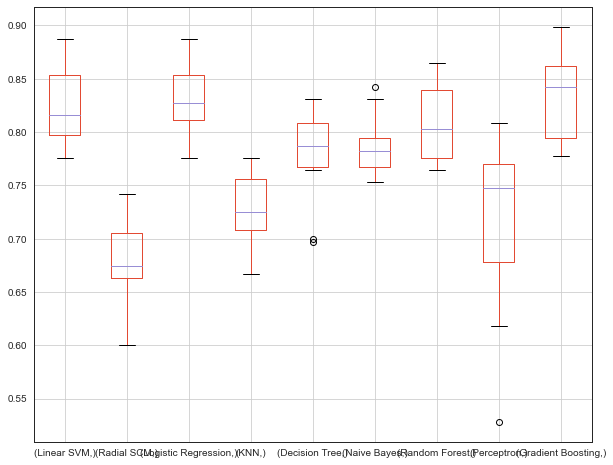

In [40]:
plt.subplots(figsize=(10, 8))
box=pd.DataFrame(accuracy,index=[classifiers])
box.T.boxplot()

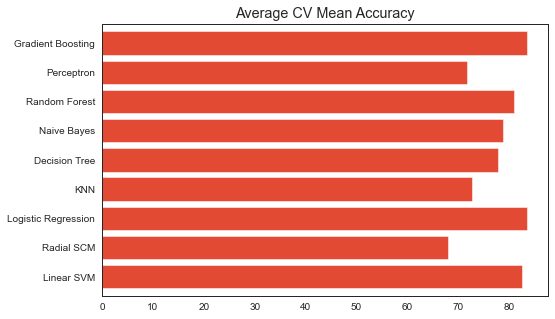

In [42]:
new_models_dataframe2['CV Mean'].plot.barh(width=0.8)
plt.title('Average CV Mean Accuracy')
fig=plt.gcf()
fig.set_size_inches(8,5)
plt.show()

## 7.4. Confusion Matrix

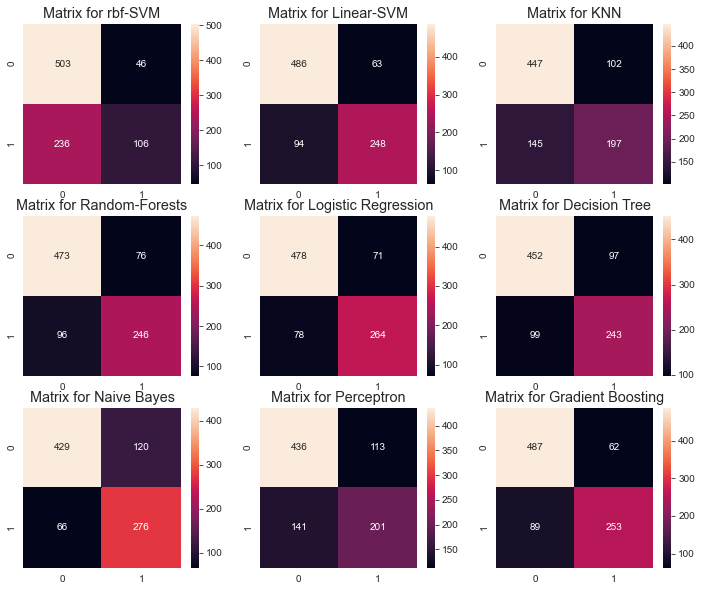

In [43]:
f,ax=plt.subplots(3,3,figsize=(12,10))

y_pred = cross_val_predict(SVC(kernel='rbf'),X,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),ax=ax[0,0],annot=True,fmt='2.0f')
ax[0,0].set_title('Matrix for rbf-SVM')

y_pred = cross_val_predict(SVC(kernel='linear'),X,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),ax=ax[0,1],annot=True,fmt='2.0f')
ax[0,1].set_title('Matrix for Linear-SVM')

y_pred = cross_val_predict(KNeighborsClassifier(n_neighbors=9),X,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),ax=ax[0,2],annot=True,fmt='2.0f')
ax[0,2].set_title('Matrix for KNN')

y_pred = cross_val_predict(RandomForestClassifier(n_estimators=100),X,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),ax=ax[1,0],annot=True,fmt='2.0f')
ax[1,0].set_title('Matrix for Random-Forests')

y_pred = cross_val_predict(LogisticRegression(),X,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),ax=ax[1,1],annot=True,fmt='2.0f')
ax[1,1].set_title('Matrix for Logistic Regression')

y_pred = cross_val_predict(DecisionTreeClassifier(),X,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),ax=ax[1,2],annot=True,fmt='2.0f')
ax[1,2].set_title('Matrix for Decision Tree')

y_pred = cross_val_predict(GaussianNB(),X,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),ax=ax[2,0],annot=True,fmt='2.0f')
ax[2,0].set_title('Matrix for Naive Bayes')

y_pred = cross_val_predict(Perceptron(),X,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),ax=ax[2,1],annot=True,fmt='2.0f')
ax[2,1].set_title('Matrix for Perceptron')

y_pred = cross_val_predict(GradientBoostingClassifier(),X,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),ax=ax[2,2],annot=True,fmt='2.0f')
ax[2,2].set_title('Matrix for Gradient Boosting')

plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()

# 8. Ensembling

## Voting Classifier

In [48]:
from sklearn.ensemble import VotingClassifier
ensemble = VotingClassifier(estimators=[
    ('knn', KNeighborsClassifier(n_neighbors=10)),
    ('rbf', SVC(probability=True,kernel='rbf',C=0.5,gamma=0.1)),
    ('rfc', RandomForestClassifier(n_estimators=500,random_state=0)),
    ('lrc', LogisticRegression(C=0.05)),
    ('dtc', DecisionTreeClassifier(random_state=0)),
    ('gnb', GaussianNB()),
    ('svm', SVC(kernel='linear',probability=True)),
#     ('ptc', Perceptron()),
    ('gbc', GradientBoostingClassifier())], voting='soft').fit(X_train, y_train)
print('The accuracy for ensembled model is:',ensemble.score(X_test, y_test))
cross = cross_val_score(ensemble,X,y, cv = 10,scoring = "accuracy")
print('The cross validated score is', cross.mean())

The accuracy for ensembled model is: 0.8171641791044776
The cross validated score is 0.8227340823970037


# 9. Submission

In [45]:
y_test_data = ensemble.predict(X_test_data)
passenger_id = data[891:].PassengerId
test = pd.DataFrame({'PassengerId': passenger_id, 'Survived': y_test_data})
test['Survived'] = test['Survived'].astype(int)
test.to_csv('titanic_pred.csv', index = False)

In [46]:
results = pd.read_csv('titanic_pred.csv')
results.head(20)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
